# Work on detection of non-megalobastic anemia

In [47]:
# Import necessary libraries
import sys
import scipy
import sklearn
import matplotlib
import seaborn

# Display the versions
print("Python version:", sys.version)
print("SciPy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", seaborn.__version__)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
SciPy version: 1.11.1
scikit-learn version: 1.6.0
Matplotlib version: 3.7.2
Seaborn version: 0.12.2


## Importation des données

In [48]:
import medstats as md
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import inspect
import re

# Utiliser la fonction import_df
df = md.import_df('data.xlsx')
df = df[df['megalo'].notna()]
df.head()

,sexe,age,atcd_fx,fx_neo,fx_anemie,fx_autoimmunite,atcd_pls_medicaux,atcd_pls_chx,alcool,tabac,medicaments,med_type,cdd,delai_dg_mois,asthenie,anorexie,amaigrissement,vertiges,dyspnee_deffort,epigastralgies,chute_de_cheveux,paresthesies_des_membres,douleurs_thoraciques,hemorragies_exteriorisee,poids,taille,bmi,temperature,paleur,tachycardie,tachypnee,vitiligo,hyperpigmentation,perleche,glossite,ictere,chute_cheveux,ongles_cassants,polyadenopayhies,hepatomegalies,splenomegalie,syndrome_pyramidal,sensibilite_profonde,sensiblite_superficielle,syndome_cerebelleux,atteinte_des_paires_craniennes,atteinte_combinee_de_la_moelle,gr,hb,vgm,tcmh,ht,rdw,reticulocytes,gb,pnn,ly,pqt,bi_ou_pancytopenie,frottis_sanguin,vs,crp,epp_protides,epp_albumine,epp_alpha1,epp_alpha2,epp_beta,epp_gama,asat,alat,ldh,bt,pal,ggt,tsh,t4,gly,uree,creat,tcd,haptoglobine,aregen,megalo,vitiligo_associe,les_associe,basdow_associe,hashimoto_associe,sgj_associe,pr_associee,dt1_associe,ice_surrenalienne_associee,maladies_associees
0,feminin,39,oui,oui,2,oui,oui,non,non,non,non,lthyroxine,fortuite,NaN,oui,non,non,non,non,non,non,non,non,non,68.0,165.0,24.90,apyretique,oui,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,1.76,8.6,112.0,32.0,36.0,17.5,42000.0,5500,NaN,NaN,176000.0,NaN,NaN,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,10.0,450.0,NaN,NaN,NaN,14.71,8.99,19.0,4.0,66.0,negative,non faite,oui,oui,non,non,non,oui,non,non,oui,non,hasimoto+dt1
1,feminin,80,oui,oui,oui,oui,non,non,non,non,oui,NaN,syndrome anemique,1.0,oui,oui,oui,oui,oui,oui,non,oui,non,ouui,49.0,150.0,21.77,apyretique,oui,non,oui,non,oui,non,oui,non,non,non,non,non,non,oui,non,non,non,non,oui,2.05,6.7,101.4,32.4,20.8,17.1,120000.0,4500,2900.0,1400.0,27000.0,bicytopenie,dacryocytes,140.0,50.0,66.5,34.65,4.99,5.32,7.78,13.77,13.0,5.0,1252.0,25.6,90.0,20.0,11.00,8.60,6.0,7.0,78.0,non fait,non faite,oui,oui,non,non,non,non,non,non,non,non,smd
2,masculin,74,non,non,2,2,oui,non,non,non,non,cordarone,au cours de la surveillance pour une autre pat...,NaN,oui,oui,oui,oui,oui,non,non,non,non,non,44.0,162.0,16.17,apyretique,oui,oui,oui,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,non,2.71,6.3,100.0,31.4,19.0,27.9,27100.0,2000,1000.0,500.0,273000.0,bicytopenie,NaN,90.0,3.0,80.0,26.60,6.30,9.20,9.00,29.00,24.0,19.0,176.0,6.0,55.0,37.0,NaN,NaN,6.3,4.3,83.0,negative,non faite,oui,oui,non,non,non,non,non,non,non,non,smd
3,masculin,64,non,non,2,2,non,non,non,non,oui,NaN,syndrome anemique,3.0,oui,non,oui,non,oui,non,non,non,non,non,60.0,168.0,21.20,apyretique,oui,oui,non,non,non,non,oui,oui,non,non,non,non,non,oui,non,non,non,non,non,1.05,5.7,119.0,34.0,25.0,25.0,25300.0,5700,3900.0,1100.0,94500.0,bicytopenie,pnn a nx hypersegmentes+poikylocytes+anisocytes,40.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,49.0,1654.0,24.0,86.0,NaN,1.29,11.70,5.1,5.8,51.0,negative,non faite,oui,oui,non,non,non,non,non,non,non,oui,insuffisance surrenalienne
4,masculin,44,non,non,2,2,oui,non,non,oui,oui,NaN,syndrome anemique,3.0,oui,oui,oui,non,oui,non,non,non,non,non,57.0,171.0,19.49,apyretique,oui,oui,non,non,non,non,non,oui,non,non,non,non,non,oui,non,non,non,non,non,1.04,4.3,131.8,35.2,13.8,36.5,14100.0,1900,900.0,1000.0,45000.0,pancytopenie,pnn a nx hypersegmentes+poikylocytes+anisocytes,80.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,3.0,6531.0,153.0,76.0,15.0,0.67,NaN,6.9,7.2,72.0,negative,non faite,oui,oui,non,non,non,non,non,non,non,oui,insuffisance surrenalienne


In [49]:
df.shape

(263, 92)

## correction de variables

In [50]:
df.rename(columns={'polyadenopayhies': 'polyadenopathies', }, inplace=True)

df['hemorragies_exteriorisee']=df['hemorragies_exteriorisee'].replace('ouui', 'oui')
df[df.columns.tolist()]=df[df.columns.tolist()].replace('non precise', np.nan)
atcd = ['atcd_fx', 'fx_neo', 'fx_anemie', 'fx_autoimmunite', 'atcd_pls_medicaux', 'atcd_pls_chx',]
df[atcd]=df[atcd].replace([2,'2'],np.nan)
df['medicaments']=df['medicaments'].replace(['.0', '00',0,00],'oui')
df['tcd']=df['tcd'].replace( 'non fait', np.nan)
df['haptoglobine']=df['haptoglobine'].replace( 'non faite', np.nan)
df['haptoglobine']=df['haptoglobine'].replace(['0.16',0.16],'basse')


In [51]:
variable_types=md.variable_types(df, seuil=5)

In [52]:
print(df.columns.tolist())

['sexe', 'age', 'atcd_fx', 'fx_neo', 'fx_anemie', 'fx_autoimmunite', 'atcd_pls_medicaux', 'atcd_pls_chx', 'alcool', 'tabac', 'medicaments', 'med_type', 'cdd', 'delai_dg_mois', 'asthenie', 'anorexie', 'amaigrissement', 'vertiges', 'dyspnee_deffort', 'epigastralgies', 'chute_de_cheveux', 'paresthesies_des_membres', 'douleurs_thoraciques', 'hemorragies_exteriorisee', 'poids', 'taille', 'bmi', 'temperature', 'paleur', 'tachycardie', 'tachypnee', 'vitiligo', 'hyperpigmentation', 'perleche', 'glossite', 'ictere', 'chute_cheveux', 'ongles_cassants', 'polyadenopathies', 'hepatomegalies', 'splenomegalie', 'syndrome_pyramidal', 'sensibilite_profonde', 'sensiblite_superficielle', 'syndome_cerebelleux', 'atteinte_des_paires_craniennes', 'atteinte_combinee_de_la_moelle', 'gr', 'hb', 'vgm', 'tcmh', 'ht', 'rdw', 'reticulocytes', 'gb', 'pnn', 'ly', 'pqt', 'bi_ou_pancytopenie', 'frottis_sanguin', 'vs', 'crp', 'epp_protides', 'epp_albumine', 'epp_alpha1', 'epp_alpha2', 'epp_beta', 'epp_gama', 'asat', 'a

# Division des variables

In [53]:
var_demo = ['sexe', 'age','poids', 'taille', 'bmi', ]
atcd = ['atcd_fx', 'fx_neo', 'fx_anemie', 'fx_autoimmunite', 'atcd_pls_medicaux', 'atcd_pls_chx',]
hdv = [ 'alcool', 'tabac', 'medicaments', ]
dg = ['cdd', 'delai_dg_mois',]
general = ['temperature', 'asthenie', 'anorexie', 'amaigrissement', 'vertiges', ]
neuro = [ 'syndrome_pyramidal', 'sensibilite_profonde', 'sensiblite_superficielle', 'syndome_cerebelleux', 'atteinte_des_paires_craniennes', 
               'atteinte_combinee_de_la_moelle','paresthesies_des_membres',]
cutanee =[ 'vitiligo', 'hyperpigmentation','ictere', 'paleur', ]
abodminal = ['hepatomegalies', 'splenomegalie','epigastralgies','hemorragies_exteriorisee',]
cadio_pulmonaire = [  'dyspnee_deffort', 'douleurs_thoraciques', 'tachycardie', 'tachypnee',]
tete_cou = ['perleche', 'glossite',]
phanere =[  'ongles_cassants', 'polyadenopathies', 'chute_de_cheveux', ]
nfs = [ 'gr', 'hb', 'vgm', 'tcmh', 'ht', 'rdw', 'reticulocytes', 'gb', 'pnn', 'ly', 'pqt', 'bi_ou_pancytopenie',]
frottis_sg = [ 'frottis_sanguin',]
epp = ['epp_protides', 'epp_albumine', 'epp_alpha1', 'epp_alpha2', 'epp_beta', 'epp_gama',]
reste_bilan = ['vs', 'crp',  'asat', 'alat', 'ldh', 'bt', 'pal', 'ggt', 'tsh', 't4', 'gly', 'uree', 'creat', 'tcd', 'haptoglobine', 'aregen', ]
manifestations_associe = ['vitiligo_associe', 'les_associe', 'basdow_associe', 'hashimoto_associe', 'sgj_associe', 'pr_associee', 'dt1_associe', 
                          'ice_surrenalienne_associee']
megalo = ['megalo']


## Analyse Descriptive

In [54]:
list_var = [var_demo, atcd,hdv , dg, general,neuro, cutanee, abodminal, cadio_pulmonaire, tete_cou, phanere, nfs,  epp,reste_bilan, 
         manifestations_associe, megalo  ]

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
    
counter = 1

for liste in list_var:
    name = get_variable_name(liste)[0]
    display(HTML(f'<b style="font-size: 25px;">I {counter} {name}</b>'))
    analyzer = md.Univariate_Analyzer(df, variable_types, liste,descriptif=True,  display_continuous=["mean", "±", "std","[","min","-","max","]"], valid_percentage=True)
    # Exécuter l'analyse pour obtenir le tableau de résultats et les variables significatives
    results_df, _ = analyzer.run_analysis()    
    # Afficher le tableau des résultats
    display(results_df)
    counter += 1

Descriptif (n=263) Pourcentage
Variable Valeur                                                 
sexe     feminin                                 131      49.81%
         masculin                                132      50.19%
age                  61.02 ± 15.97 [ 16.00 - 90.00 ]            
poids               66.18 ± 14.16 [ 41.00 - 102.00 ]            
taille             161.08 ± 13.13 [ 94.00 - 183.00 ]            
bmi                   25.62 ± 8.28 [ 13.90 - 90.20 ]

Descriptif (n=263) Pourcentage
Variable          Valeur                               
atcd_fx           non                   215      87.76%
                  oui                    30      12.24%
fx_neo            non                   215      87.76%
                  oui                    30      12.24%
fx_anemie         non                    16      66.67%
                  oui                     8      33.33%
fx_autoimmunite   non                    17      53.12%
                  oui                    15      46.88%
atcd_pls_medicaux non                    84      32.18%
                  oui                   177      67.82%
atcd_pls_chx      non                   195      75.00%
                  oui                    65      25.00%

Descriptif (n=263) Pourcentage
Variable    Valeur                               
alcool      non                   197      92.49%
            oui                    16       7.51%
tabac       non                   174      81.31%
            oui                    40      18.69%
medicaments non                    69      28.75%
            oui                   171      71.25%

Descriptif (n=263)  \
Variable      Valeur                                                                             
cdd           anemie ferriprive                                                              2   
              au cours de la surveillance pour une autre path...                            29   
              au cours du suivi pour hypothyroidie                                           4   
              fortuite                                                                      49   
              syndrome anemique                                                            173   
              tvp                                                                            5   
delai_dg_mois                                                     3.40 ± 2.16 [ 1.00 - 12.00 ]   

                                                                 Pourcentage  
Variable      Valeur                                                          
cdd           anemie ferriprive                                        0.76%  
              au cours de la surveillance pour une autre path...      11.07%  
              au cours du suivi pour hypothyroidie                     1.53%  
              fortuite                                                18.70%  
              syndrome anemique                                       66.03%  
              tvp                                                      1.91%  
delai_dg_mois

Descriptif (n=263) Pourcentage
Variable       Valeur                                   
temperature    apyretique                201      95.26%
               febrile                    10       4.74%
asthenie       non                        27      10.55%
               oui                       229      89.45%
anorexie       non                       105      42.34%
               oui                       143      57.66%
amaigrissement non                       142      53.99%
               oui                       121      46.01%
vertiges       non                       148      56.27%
               oui                       115      43.73%

Descriptif (n=263) Pourcentage
Variable                       Valeur                               
syndrome_pyramidal             non                   243      92.75%
                               oui                    19       7.25%
sensibilite_profonde           non                   256      97.34%
                               oui                     7       2.66%
sensiblite_superficielle       non                   238      90.49%
                               oui                    25       9.51%
syndome_cerebelleux            non                   256      97.34%
                               oui                     7       2.66%
atteinte_des_paires_craniennes non                   259      98.48%
                               oui                     4       1.52%
atteinte_combinee_de_la_moelle non                   254      96.95%
                               oui                     8       3.05%
paresthesies_des_membres       non                   205      77.95%
                               oui                    58      22.05%

Descriptif (n=263) Pourcentage
Variable          Valeur                               
vitiligo          non                   249      94.68%
                  oui                    14       5.32%
hyperpigmentation non                   250      95.06%
                  oui                    13       4.94%
ictere            non                   204      77.57%
                  oui                    59      22.43%
paleur            non                    75      28.63%
                  oui                   187      71.37%

Descriptif (n=263) Pourcentage
Variable                 Valeur                               
hepatomegalies           non                   251      95.44%
                         oui                    12       4.56%
splenomegalie            non                   246      93.54%
                         oui                    17       6.46%
epigastralgies           non                   212      80.61%
                         oui                    51      19.39%
hemorragies_exteriorisee non                   260      98.86%
                         oui                     3       1.14%

Descriptif (n=263) Pourcentage
Variable             Valeur                               
dyspnee_deffort      non                   157      59.70%
                     oui                   106      40.30%
douleurs_thoraciques non                   252      95.82%
                     oui                    11       4.18%
tachycardie          non                   194      74.05%
                     oui                    68      25.95%
tachypnee            non                   244      93.49%
                     oui                    17       6.51%

Descriptif (n=263) Pourcentage
Variable Valeur                               
perleche non                   262      99.62%
         oui                     1       0.38%
glossite non                   163      61.98%
         oui                   100      38.02%

Descriptif (n=263) Pourcentage
Variable         Valeur                               
ongles_cassants  non                   258      98.10%
                 oui                     5       1.90%
polyadenopathies non                   258      98.10%
                 oui                     5       1.90%
chute_de_cheveux non                   249      94.68%
                 oui                    14       5.32%

,,Descriptif (n=263),Pourcentage
Variable,Valeur,,
gr,,2.20 ± 0.98 [ 0.58 - 6.71 ],
hb,,7.36 ± 2.36 [ 3.00 - 12.90 ],
vgm,,113.69 ± 10.96 [ 100.00 - 162.10 ],
tcmh,,35.55 ± 5.07 [ 20.77 - 50.50 ],
ht,,23.43 ± 8.25 [ 8.80 - 47.00 ],
rdw,,23.69 ± 7.52 [ 12.00 - 49.00 ],
reticulocytes,,70755.19 ± 104889.59 [ 2430.00 - 1135690.00 ],
gb,,6421.14 ± 12704.35 [ 900.00 - 151000.00 ],
pnn,,3494.06 ± 9018.67 [ 270.00 - 140000.00 ],


,,Descriptif (n=263)
Variable,Valeur,
epp_protides,,64.64 ± 8.25 [ 46.00 - 94.00 ]
epp_albumine,,35.21 ± 7.22 [ 10.70 - 62.00 ]
epp_alpha1,,3.13 ± 1.21 [ 0.50 - 6.80 ]
epp_alpha2,,6.09 ± 1.99 [ 3.30 - 13.57 ]
epp_beta,,7.13 ± 2.54 [ 3.00 - 14.80 ]
epp_gama,,13.19 ± 8.48 [ 3.20 - 76.70 ]


,,Descriptif (n=263),Pourcentage
Variable,Valeur,,
vs,,57.41 ± 41.63 [ 2.00 - 150.00 ],
crp,,9.55 ± 19.31 [ 0.00 - 120.00 ],
asat,,36.28 ± 35.70 [ 6.00 - 300.00 ],
alat,,26.06 ± 31.70 [ 3.00 - 390.00 ],
ldh,,1628.00 ± 1908.61 [ 12.40 - 10170.00 ],
bt,,25.73 ± 25.20 [ 2.00 - 191.00 ],
pal,,81.33 ± 53.00 [ 4.40 - 285.00 ],
ggt,,22.18 ± 19.66 [ 0.00 - 145.00 ],
tsh,,8.05 ± 30.16 [ 0.07 - 286.70 ],


Descriptif (n=263) Pourcentage
Variable                   Valeur                               
vitiligo_associe           non                   239      95.22%
                           oui                    12       4.78%
les_associe                non                   249      98.81%
                           oui                     3       1.19%
basdow_associe             non                   248      98.41%
                           oui                     4       1.59%
hashimoto_associe          non                   249      98.81%
                           oui                     3       1.19%
sgj_associe                non                   249      98.81%
                           oui                     3       1.19%
pr_associee                non                   249      98.81%
                           oui                     3       1.19%
dt1_associe                non                   247      98.02%
                           oui                     5       1.98%
ice_surrenalienne_associee non                   241      95.63%
                           oui                    11       4.37%

Descriptif (n=263) Pourcentage
Variable Valeur                               
megalo   non                    39      14.83%
         oui                   224      85.17%

## Analyse univariee en fonction de megalo

In [55]:
list_var = [var_demo, atcd,hdv , dg, general,neuro, cutanee, abodminal, cadio_pulmonaire, tete_cou, phanere, nfs,  epp,reste_bilan, 
         manifestations_associe  ]

def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

counter = 1
all_significant_variables = []

for liste in list_var:
    name = get_variable_name(liste)[0]
    display(HTML(f'<b style="font-size: 25px;">I {counter} {name}</b>'))
    analyzer = md.Univariate_Analyzer(df, variable_types, liste,variable2='megalo',descriptif=False,  display_continuous=["mean", "±", "std"],pval=0.05, absolut_fisher=True, valid_percentage=True)
    # Exécuter l'analyse pour obtenir le tableau de résultats et les variables significatives
    results_df, significant_variables = analyzer.run_analysis()
    # Afficher le tableau des résultats
    display(results_df)
    
    display(HTML(f'<b>Variables significatives pour {name}:</b> {significant_variables}'))

    # Ajouter les variables significatives à la liste globale
    all_significant_variables.append(significant_variables)
    counter += 1


# Fusionner toutes les sous-listes en une seule liste
all_significant_variables_flat = [variable for sublist in all_significant_variables for variable in sublist]
display(HTML(f'<b>Variables significatives pour tous les tableaux :</b> {all_significant_variables_flat}'))

,,megalo = non (n=39),megalo = oui (n=224),p_value
Variable,Valeur,,,
gr,,2.37 ± 0.89,2.17 ± 0.99,0.137
hb,,7.49 ± 2.04,7.33 ± 2.41,0.700
vgm,,106.87 ± 5.15,114.87 ± 11.27,<0.001
tcmh,,33.42 ± 3.03,35.85 ± 5.23,0.030
ht,,24.44 ± 8.85,23.34 ± 8.21,0.733
rdw,,21.94 ± 5.64,23.84 ± 7.66,0.505
reticulocytes,,130137.50 ± 218366.04,60297.92 ± 63781.50,0.006
gb,,15323.85 ± 31216.31,4871.12 ± 2702.20,0.023
pnn,,7379.11 ± 23145.08,2843.54 ± 2107.46,0.606


,,megalo = non (n=39),megalo = oui (n=224),p_value
Variable,Valeur,,,
epp_protides,,65.06 ± 13.45,64.61 ± 7.83,0.882
epp_albumine,,27.58 ± 8.15,35.85 ± 6.80,0.001
epp_alpha1,,3.02 ± 1.81,3.14 ± 1.17,0.782
epp_alpha2,,8.79 ± 2.79,5.89 ± 1.78,0.002
epp_beta,,8.08 ± 2.18,7.06 ± 2.56,0.278
epp_gama,,20.53 ± 21.24,12.23 ± 4.30,0.876


,,megalo = non (n=39),megalo = oui (n=224),p_value
Variable,Valeur,,,
vs,,92.85 ± 48.30,52.24 ± 38.08,<0.001
crp,,19.53 ± 36.43,8.37 ± 16.02,0.735
asat,,27.63 ± 28.48,38.07 ± 36.84,0.008
alat,,20.60 ± 16.86,27.18 ± 33.89,0.101
ldh,,816.19 ± 1379.64,1773.46 ± 1956.34,0.001
bt,,24.59 ± 27.08,25.96 ± 24.88,0.107
pal,,87.74 ± 61.43,80.19 ± 51.53,0.607
ggt,,31.37 ± 32.44,19.79 ± 14.05,0.090
tsh,,24.90 ± 72.69,6.02 ± 19.51,0.227


## Recapitulatif des variables significatives

In [56]:
variables_retirees = ['cdd', 'epp_albumine', 'epp_alpha2','tcd','reticulocytes','t4', 'atteinte_des_paires_craniennes',]

variable_analyse = ['sexe', 'age', 'vertiges', 'paresthesies_des_membres', 'hepatomegalies', 'splenomegalie', 'glossite',
 'polyadenopathies', 'vgm', 'tcmh', 'gb', 'asat','vs', 'ldh', 'creat', 'aregen']

analyzer = md.Univariate_Analyzer(df, variable_types, variable_analyse,variable2='megalo',descriptif=True,  display_continuous=["mean", "±", "std"],pval=0.05, absolut_fisher=True, valid_percentage=True)
# Exécuter l'analyse pour obtenir le tableau de résultats et les variables significatives
results_df, significant_variables = analyzer.run_analysis()
# Afficher le tableau des résultats
display(results_df)

## Analyse des valeurs manquantes a partir des variables retenues

Number of rows with at least one missing value: 141


,Variable,Missing Values
0,vertiges,0
1,paresthesies_des_membres,0
2,hepatomegalies,0
3,splenomegalie,0
4,glossite,0
5,polyadenopathies,0
6,vs,106
7,vgm,0
8,tcmh,28
9,gb,0


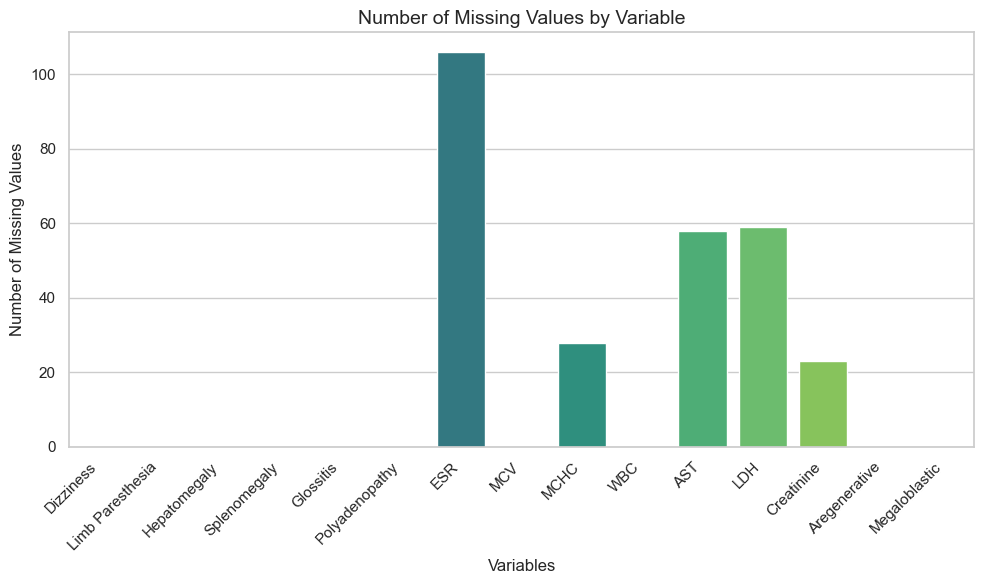

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des variables à analyser
variable_analyser = ['vertiges',  'paresthesies_des_membres', 'hepatomegalies', 
                     'splenomegalie', 'glossite', 'polyadenopathies','vs', 'vgm', 'tcmh', 'gb', 'asat', 
                     'ldh', 'creat', 'aregen', 'megalo']

# Traductions des labels en anglais pour l'affichage du graphique
variable_labels = {
    'vertiges': 'Dizziness', 
    'paresthesies_des_membres': 'Limb Paresthesia', 
    'hepatomegalies': 'Hepatomegaly', 
    'splenomegalie': 'Splenomegaly', 
    'glossite': 'Glossitis', 
    'polyadenopathies': 'Polyadenopathy', 
    'vgm': 'MCV', 
    'tcmh': 'MCHC', 
    'gb': 'WBC', 
    'vs':'ESR',
    'asat': 'AST', 
    'ldh': 'LDH', 
    'creat': 'Creatinine', 
    'aregen': 'Aregenerative', 
    'megalo': 'Megaloblastic'
}

# Nombre de lignes contenant au moins une valeur manquante
nb_lignes_avec_manquantes = df[variable_analyser].isna().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {nb_lignes_avec_manquantes}")

# Nombre de valeurs manquantes par variable
nb_valeurs_manquantes_par_variable = df[variable_analyser].isna().sum()

# Création d'un tableau
resultat = pd.DataFrame({
    "Variable": variable_analyser,
    "Missing Values": nb_valeurs_manquantes_par_variable.values
})

display(resultat)

df_filtered = df[variable_analyser]

# Calculer le nombre de valeurs manquantes
missing_counts = df_filtered.isnull().sum()

# Créer le graphique avec seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')

# Remplacer les labels des variables par leurs traductions en anglais
plt.xticks(ticks=range(len(missing_counts.index)), labels=[variable_labels[var] for var in missing_counts.index], rotation=45, ha='right')

plt.title("Number of Missing Values by Variable", fontsize=14)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xlabel("Variables", fontsize=12)
plt.tight_layout()
plt.savefig('missing_values_by_variable.png')

plt.show()


## Imputation des valeurs manquantes

In [58]:
import pandas as pd
from sklearn.impute import KNNImputer

# Variables avec des valeurs manquantes
variable_missing = ['tcmh', 'asat', 'ldh', 'creat','vs']
# Variables à utiliser pour l'imputation
all_features = ['sexe', 'age', 'bmi', 'vertiges', 
                'paresthesies_des_membres', 'hepatomegalies', 'splenomegalie', 
                'glossite', 'polyadenopathies', 'vs','vgm', 'tcmh', 'gb', 
                'asat', 'ldh', 'creat', 'aregen']
df['sexe']=df['sexe'].replace({'feminin':0, 'masculin':1})
df[all_features]=df[all_features].replace({'non':0,'oui':1})
df['megalo']=df['megalo'].replace({'non':1,'oui':0})
# Diviser les données par groupe 'megalo'
imputed_data = []

for group, group_df in df.groupby('megalo'):
    # Extraire les colonnes pertinentes pour l'imputation
    group_data = group_df[all_features]
    
    # Instancier le KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    
    # Appliquer l'imputation
    imputed_group_data = pd.DataFrame(imputer.fit_transform(group_data), 
                                      columns=all_features, 
                                      index=group_data.index)
    
    # Remplacer les colonnes avec valeurs imputées
    group_df[variable_missing] = imputed_group_data[variable_missing]
    
    # Ajouter le groupe traité à la liste
    imputed_data.append(group_df)

# Réassembler les groupes
df = pd.concat(imputed_data)

## Reanalayse des variables apres imputation

In [59]:
df['sexe']=df['sexe'].replace({0:'feminin', 1:'masculin'})
df[all_features]=df[all_features].replace({0:'non',1:'oui'})
df['megalo']=df['megalo'].replace({1:'non',0:'oui'})

var_to_analyse = ['tcmh', 'asat', 'ldh', 'creat','vs']

analyzer = md.Univariate_Analyzer(df, variable_types, var_to_analyse,variable2='megalo',descriptif=False,  display_continuous=["mean", "±", "std"],pval=0.05, absolut_fisher=True, valid_percentage=True)
# Exécuter l'analyse pour obtenir le tableau de résultats et les variables significatives
results_df_2, significant_variables = analyzer.run_analysis()
# Afficher le tableau des résultats
display(results_df_2)

,,megalo = non (n=39),megalo = oui (n=224),p_value
Variable,Valeur,,,
tcmh,,33.72 ± 2.67,35.88 ± 5.08,0.033
asat,,28.31 ± 27.14,36.70 ± 32.63,0.005
ldh,,864.99 ± 1261.57,1753.86 ± 1761.21,<0.001
creat,,109.79 ± 102.40,78.10 ± 28.65,0.004
vs,,92.98 ± 35.04,51.11 ± 31.19,<0.001


## tableau descriptif et analyse avant et aprés imputation

In [60]:
# Suppression d'éventuels objets Styler (si applicable)
if isinstance(results_df, pd.io.formats.style.Styler):
    results_df = results_df.data

if isinstance(results_df_2, pd.io.formats.style.Styler):
    results_df_2 = results_df_2.data

# Concaténation avec multi-index
results_concat = pd.concat(
    [results_df, results_df_2],
    axis=1,
    keys=["Avant imputation", "Après imputation"]
)
results_concat = results_concat.fillna('')

# Affichage du résultat
results_concat

Avant imputation                       \
                                   Descriptif (n=263)  megalo = non (n=39)   
Variable                 Valeur                                              
sexe                     feminin         131 (49.81%)          19 (48.72%)   
                         masculin        132 (50.19%)          20 (51.28%)   
age                                     61.02 ± 15.97        64.95 ± 16.97   
vertiges                 non             148 (56.27%)          30 (76.92%)   
                         oui             115 (43.73%)           9 (23.08%)   
paresthesies_des_membres non             205 (77.95%)          37 (94.87%)   
                         oui              58 (22.05%)            2 (5.13%)   
hepatomegalies           non             251 (95.44%)          34 (87.18%)   
                         oui               12 (4.56%)           5 (12.82%)   
splenomegalie            non             246 (93.54%)          31 (79.49%)   
                         oui               17 (6.46%)           8 (20.51%)   
glossite                 non             163 (61.98%)          35 (89.74%)   
                         oui             100 (38.02%)           4 (10.26%)   
polyadenopathies         non             258 (98.10%)          34 (87.18%)   
                         oui                5 (1.90%)           5 (12.82%)   
vgm                                    113.69 ± 10.96        106.87 ± 5.15   
tcmh                                     35.55 ± 5.07         33.42 ± 3.03   
gb                                 6421.14 ± 12704.35  15323.85 ± 31216.31   
asat                                    36.28 ± 35.70        27.63 ± 28.48   
vs                                      57.41 ± 41.63        92.85 ± 48.30   
ldh                                 1628.00 ± 1908.61     816.19 ± 1379.64   
creat                                   83.02 ± 50.57      109.95 ± 103.77   
aregen                   non               25 (9.51%)          10 (25.64%)   
                         oui             238 (90.49%)          29 (74.36%)   

                                                                \
                                  megalo = oui (n=224) p_value   
Variable                 Valeur                                  
sexe                     feminin          112 (50.00%)   1.000   
                         masculin         112 (50.00%)           
age                                      60.33 ± 15.73   0.087   
vertiges                 non              118 (52.68%)   0.008   
                         oui              106 (47.32%)           
paresthesies_des_membres non              168 (75.00%)   0.011   
                         oui               56 (25.00%)           
hepatomegalies           non              217 (96.88%)   0.024   
                         oui                 7 (3.12%)           
splenomegalie            non              215 (95.98%)  <0.001   
                         oui                 9 (4.02%)           
glossite                 non              128 (57.14%)  <0.001   
                         oui               96 (42.86%)           
polyadenopathies         non             224 (100.00%)  <0.001   
                         oui                 0 (0.00%)           
vgm                                     114.87 ± 11.27  <0.001   
tcmh                                      35.85 ± 5.23   0.030   
gb                                   4871.12 ± 2702.20   0.023   
asat                                     38.07 ± 36.84   0.008   
vs                                       52.24 ± 38.08  <0.001   
ldh                                  1773.46 ± 1956.34   0.001   
creat                                    77.96 ± 29.92   0.006   
aregen                   non                15 (6.70%)   0.001   
                         oui              209 (93.30%)           

                                     Après imputation                       \
                                  megalo = non (n=39) megalo = oui (n

## Feature selection by SequentialFeatureSelector

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

df_feature = df.copy()


all_features = [ 'vertiges',  'hepatomegalies', 'splenomegalie', 
                'glossite', 'polyadenopathies','vs', 'vgm','paresthesies_des_membres', 'tcmh', 'gb',
                'asat', 'ldh', 'creat', 'aregen']

df_feature[all_features]=df_feature[all_features].replace({'non':0,'oui':1})
df_feature['megalo']=df_feature['megalo'].replace({'non':1,'oui':0})


# Diviser les données en X et y
X = df_feature[all_features]
y = df_feature['megalo']

# Séparer les variables continues et catégoriques
continues_vars = [var for var in all_features if variable_types[var] == 'continues']
categorical_vars = [var for var in all_features if variable_types[var] == 'categorique']

# Division des données en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalisation des variables continues
scaler = StandardScaler()
X_train[continues_vars] = scaler.fit_transform(X_train[continues_vars])
X_test[continues_vars] = scaler.transform(X_test[continues_vars])

# Création du modèle de régression logistique
log_reg = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Sélection séquentielle des caractéristiques avec ROC AUC comme métrique
selector = SequentialFeatureSelector(log_reg, 
                                     n_features_to_select='auto', 
                                     direction='backward',  
                                     scoring='recall', 
                                     cv=cv)  

# Appliquer le SFS sur les données d'entraînement
selector.fit(X_train, y_train)

# Afficher les variables sélectionnées
selected_features = X_train.columns[selector.get_support()]
print("Variables sélectionnées :")
print(selected_features)



Variables sélectionnées :
Index(['glossite', 'vs', 'vgm', 'paresthesies_des_membres', 'tcmh', 'ldh',
       'aregen'],
      dtype='object')


## model creation

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Meilleurs paramètres :
{'log_reg__C': 0.1, 'log_reg__class_weight': 'balanced', 'log_reg__penalty': 'l2', 'log_reg__solver': 'newton-cg'}


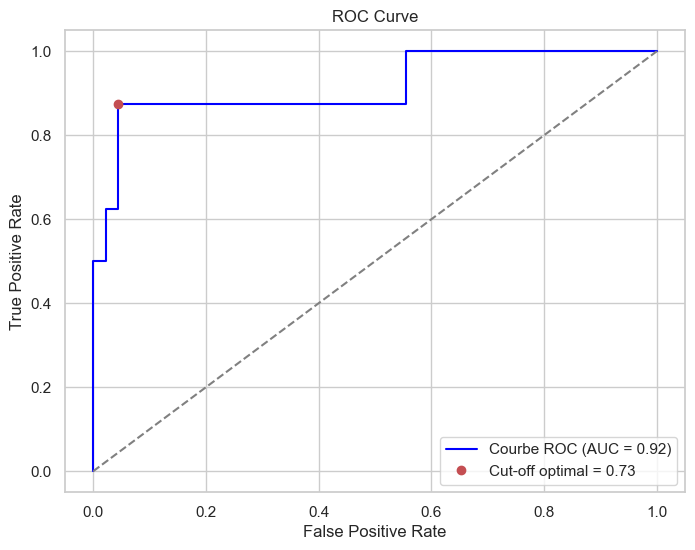

Seuil optimal : 0.73
Accuracy : 0.94
Sensibilité (Recall) : 0.96
Spécificité : 0.88
[[43  2]
 [ 1  7]]


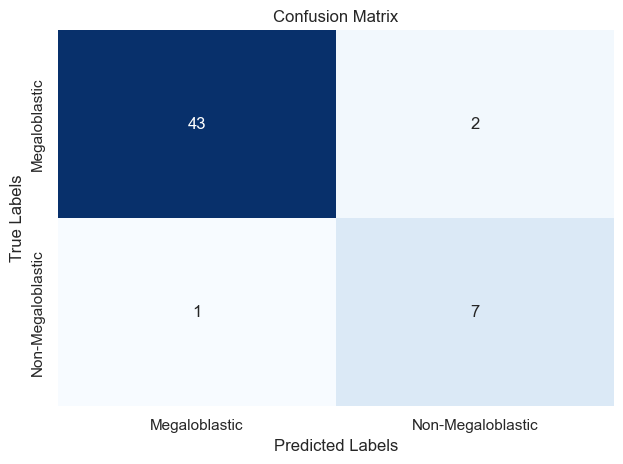

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.78      0.88      0.82         8

    accuracy                           0.94        53
   macro avg       0.88      0.92      0.89        53
weighted avg       0.95      0.94      0.94        53



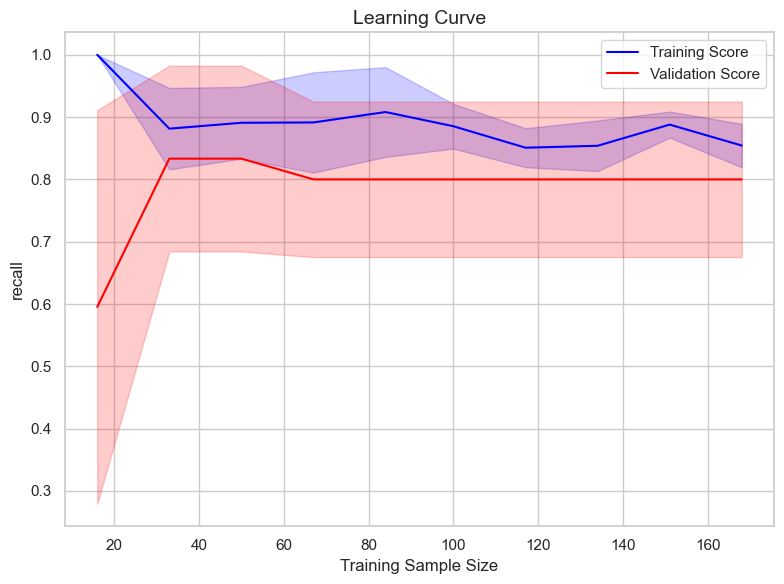

['best_logistic_model_pipeline.joblib']

In [62]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder


# Remplacer 'non' par 1 et 'oui' par 0 dans la variable cible
df['megalo'] = df['megalo'].replace({'non': 1, 'oui': 0})

# Sélectionner les variables continues et catégoriques
continues_vars = [var for var in selected_features if variable_types[var] == 'continues']
categorical_vars = [var for var in selected_features if variable_types[var] == 'categorique']
df[categorical_vars]=df[categorical_vars].replace({'non':0,'oui':1})

# Diviser les données en X (variables indépendantes) et y (variable cible)
X = df[continues_vars + categorical_vars]
y = df['megalo']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Création du pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), continues_vars),  # Normaliser les variables continues
    ], 
    remainder='passthrough'  # Laisser les autres variables inchangées
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(random_state=42))
])

# Paramètres à tester avec GridSearchCV
param_grid = {
    'log_reg__C': [0.1, 1, 10, 100],  # Régularisation L2
    'log_reg__penalty': ['l2',None],  # Pénalité
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear','saga','newton-cholesky'],  # Solvers
    'log_reg__class_weight': ['balanced', None]  # Gestion du déséquilibre des classes
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='recall', cv=cv, n_jobs=-1, verbose=1)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres :")
print(grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire
best_model = grid_search.best_estimator_

# Prédictions sur les données de test
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Trouver le seuil optimal
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Affichage du cut-off point
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f"Cut-off optimal = {optimal_threshold:.2f}")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_Curve.png', dpi=300)
plt.show()

print(f"Seuil optimal : {optimal_threshold:.2f}")

# Prédictions en utilisant le seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calcul des métriques
accuracy = (y_pred_optimal == y_test).mean()
sensitivity = (y_pred_optimal[y_test == 0] == 0).mean()  # Sensibilité = Recall de 'non' (1)
specificity = (y_pred_optimal[y_test == 1] == 1).mean()  # Spécificité = Recall de 'oui' (0)

# Affichage des métriques
print(f"Accuracy : {accuracy:.2f}")
print(f"Sensibilité (Recall) : {sensitivity:.2f}")
print(f"Spécificité : {specificity:.2f}")

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_optimal)
print(cm)
# Heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Megaloblastic', 'Non-Megaloblastic'], 
            yticklabels=['Megaloblastic', 'Non-Megaloblastic'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save the image
plt.savefig('Confusion_Matrix.png', dpi=300)
plt.show()

# Affichage du classification report
print(classification_report(y_test, y_pred_optimal))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Affichage de la learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, 
    cv=cv,  # Validation croisée stratifiée
    scoring='recall',  # Utilisation de l'AUC pour la mesure de la performance
    n_jobs=-1,  # Utilisation de tous les cœurs
    train_sizes=np.linspace(0.1, 1.0, 10)  # Taille des échantillons d'entraînement
)

# Moyenne et écart type des scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Affichage de la courbe d'apprentissage
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Score', color='red')

# Affichage des intervalles de confiance
plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes, 
                 test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, 
                 alpha=0.2, color='red')

# Titles and labels
plt.title('Learning Curve', fontsize=14)
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('recall', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save the image
plt.savefig('Learning_Curve.png', dpi=300)
plt.show()


# Exporter la pipeline
joblib.dump(best_model, 'best_logistic_model_pipeline.joblib')

In [63]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['vs', 'vgm', 'tcmh',
                                                   'ldh'])])),
                ('log_reg',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    random_state=42, solver='newton-cg'))])

# example of prediction

In [64]:
selected_features=[ 'glossite', 'vs', 'vgm', 'paresthesies_des_membres', 'tcmh', 'ldh',
       'aregen']
# Faire une prédiction avec des données spécifiques
input_data = {
     'glossite':0,
    'vs':45, 
    'vgm':80,
    'paresthesies_des_membres':0, 
    'tcmh':33, 
    'ldh':400,
   'aregen':1
}

# Convertir en DataFrame
input_df = pd.DataFrame([input_data])

# Prédiction de probabilité
probability = best_model.predict_proba(input_df)[:, 1][0]

# Appliquer un seuil personnalisé
threshold = 0.69
prediction = "Non-Megaloblastic Anemia" if probability > threshold else "Megaloblastic Anemia"

# Afficher les résultats
print(f"Prediction: {prediction}")
print(f"Probability of Non-Megaloblastic Anemia: {probability:.2f}")

Prediction: Non-Megaloblastic Anemia
Probability of Non-Megaloblastic Anemia: 0.87


## Relative Feature Importance

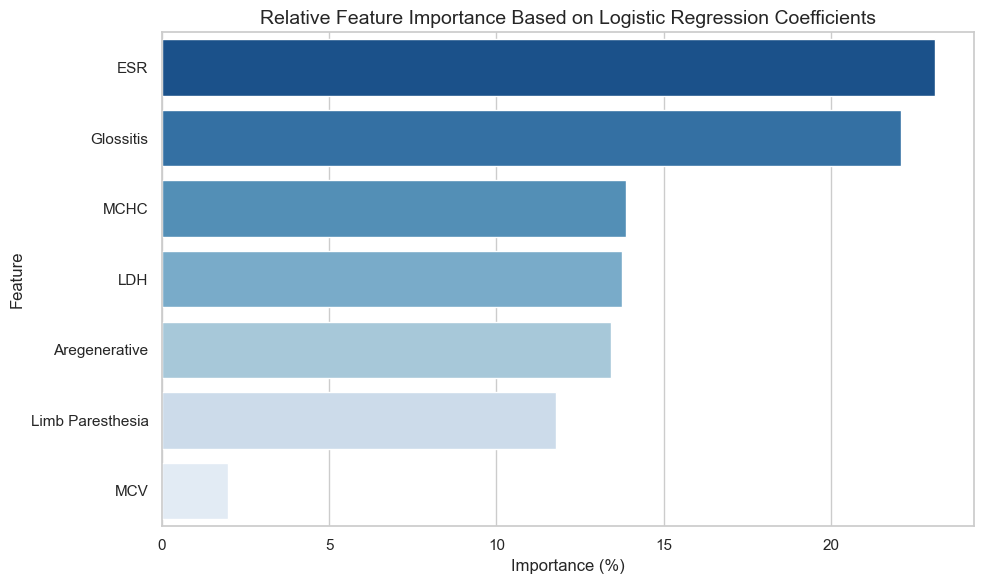

In [65]:
# Traductions des labels en anglais pour l'affichage du graphique
variable_labels = {
    'vertiges': 'Dizziness', 
    'paresthesies_des_membres': 'Limb Paresthesia', 
    'hepatomegalies': 'Hepatomegaly', 
    'splenomegalie': 'Splenomegaly', 
    'glossite': 'Glossitis', 
    'polyadenopathies': 'Polyadenopathy', 
    'vgm': 'MCV', 
    'tcmh': 'MCHC', 
    'gb': 'WBC', 
    'asat': 'AST', 
    'ldh': 'LDH', 
    'vs':'ESR',
    'creat': 'Creatinine', 
    'aregen': 'Aregenerative', 
    'megalo': 'Megaloblastic'
}

# Extraire le meilleur modèle à partir de GridSearchCV
best_model = grid_search.best_estimator_

# Extraire les coefficients du modèle de régression logistique
coefficients = best_model.named_steps['log_reg'].coef_[0]  # log_reg est le nom du modèle dans le pipeline
variables = selected_features  # Les variables sélectionnées par le SFS

# Créer un DataFrame des variables et de leurs coefficients
coef_df = pd.DataFrame({
    'Variable': variables,
    'Coefficient': coefficients
})
# Calculer l'importance relative des variables en pourcentage
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
total_abs_coef = coef_df['Abs_Coefficient'].sum()  # Somme des coefficients absolus
coef_df['Importance (%)'] = (coef_df['Abs_Coefficient'] / total_abs_coef) * 100  # Calcul du pourcentage

# Trier le DataFrame par 'Importance (%)' pour afficher les variables les plus importantes en premier
coef_df = coef_df.sort_values(by='Importance (%)', ascending=False)

# Remplacer les noms des variables par leurs traductions en anglais
coef_df['Variable'] = coef_df['Variable'].map(variable_labels)

# Définir le style de Seaborn pour un graphique épuré
sns.set(style="whitegrid")

# Créer le graphique en barres horizontales
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance (%)', y='Variable', data=coef_df, palette='Blues_r')

# Ajouter les labels et le titre
plt.xlabel('Importance (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Relative Feature Importance Based on Logistic Regression Coefficients', fontsize=14)

# Ajuster la disposition
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig('Feature_Importance.png', dpi=300)

# Afficher le graphique
plt.show()
